In [14]:
import keras 
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
import itertools
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
np.random.seed(420) 

In [16]:
def create_feedforward_network(model, hidden_sizes, input_shape=None):
    count = 0
    for size in hidden_sizes:
        if count == 0 and input_shape is not None:
            model.add(Dense(size, activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Dense(size, activation='relu'))

In [17]:
def create_convolutional_network(model, conv_sizes, fc_sizes, input_shape):
    #structure: conv, pool, conv, pool and so on 
    count = 0
    for size in conv_sizes:    
        num_filters, kernel_size, pool_size = size
        if count == 0:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Flatten())
    create_feedforward_network(model, fc_sizes)

In [18]:
def create_network(hidden_sizes, num_outputs, do_regression, use_fc=True, conv_sizes=None, input_shape=None, optimizer='adam'):
    model = Sequential()
    if use_fc:
        create_feedforward_network(model, hidden_sizes, input_shape)
    else:
        create_convolutional_network(model, conv_sizes, hidden_sizes, input_shape)
    if do_regression:
        model.add(Dense(num_outputs))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
    else:
        model.add(Dense(num_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model


In [19]:
def get_fc_data():
    ''' 
    assume data is of the form:
    each row of X is [x1, x2, a, b] where c = a+bi and x1, x2 are the mapped point 
    Y is a vector with 0/1 values that represent if that particular pixel location + c-value diverge or not
    '''
    X = np.load('X.npy')
    Y = np.load('Y.npy')
    Y = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test


In [20]:
def subSample(anArray, reductionFactor,shouldDraw=False):
    #Note that reductionFactor is a float between 0 and 1
    #Also note reductionFactor is per dimension (so for us, the true size reduction is
    #   reductionFactor squared)
    xSamples = np.linspace(0,255,int(255*reductionFactor),dtype=int)
    ySamples = np.linspace(0,383,int(383*reductionFactor),dtype=int)
    ans = anArray[np.ix_(xSamples, ySamples)]
    if shouldDraw:
        plt.figure()
        plt.imshow(ans, cmap="gray")
        plt.figure()
        plt.imshow(anArray, cmap="gray")
    return ans

In [21]:
def get_conv_data():
    Y = np.load('C_values.npy')#batch size by 2 matrix
    reduction_factor = 1
    img_shape = [int(256*reduction_factor), int(384*reduction_factor)]
    X = np.zeros((Y.shape[0], *img_shape))#images
    base = 'data/julia'
    for i in range(Y.shape[0]):
        img = np.load(base+str(i)+'.npy')
#         img = subSample(img, reduction_factor)
        X[i] = img
    X = np.reshape(X, (*X.shape, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test, img_shape

In [22]:
def f(z, c):   #iterating function
    return z * z + c
def does_diverge(z, c, iters):  #checks if a given pixel diverges
#     iters = 3
    for _ in range(iters):
        z = f(z, c)
        if abs(z) > 2: # Diverges
            return 1
    return 0
def generate_julia_set(size, c=False, iterations=50):
    x = np.linspace(-2, 2, size * 3)
    y = np.linspace(-1, 1, size * 2)
    X = np.array(list(itertools.product(y, x)))[:, (1, 0)]
    if not c:
        output = np.array([does_diverge(complex(*sample), complex(*sample), iterations) for sample in X])
    else:
        output = np.array([does_diverge(complex(*sample), c, iterations) for sample in X])
    return X, output.reshape((size * 2, size * 3)) #image format

In [23]:
Xtrain_fc, Xtest_fc, ytrain_fc, ytest_fc = get_fc_data()

In [100]:
#iterate through different architectures and train the models (classify a particular a 
# a particular point and c value as diverges/converges)
fc_architectures = [[128, 64, 32], [512, 256, 128, 64, 32], [1024, 512, 256, 128, 64, 32]]
histories = []
batch_size = 2048
num_epochs = 10
for architecture in fc_architectures:
    fc_model = create_network(architecture, 2, False, input_shape=[4])
    hist = fc_model.fit(Xtrain_fc, ytrain_fc, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.2)
    histories.append(hist)

Train on 3529624 samples, validate on 882406 samples
Epoch 1/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.1340 - acc: 0.9394 - val_loss: 0.0952 - val_acc: 0.9584
Epoch 2/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.0897 - acc: 0.9605 - val_loss: 0.0856 - val_acc: 0.9626
Epoch 3/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.0842 - acc: 0.9628 - val_loss: 0.0881 - val_acc: 0.9600
Epoch 4/10
3529624/3529624 [==============================] - 11s 3us/step - loss: 0.0809 - acc: 0.9643 - val_loss: 0.0807 - val_acc: 0.9644
Epoch 5/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.0784 - acc: 0.9653 - val_loss: 0.0761 - val_acc: 0.9666
Epoch 6/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.0764 - acc: 0.9661 - val_loss: 0.0774 - val_acc: 0.9662
Epoch 7/10
3529624/3529624 [==============================] - 12s 3us/step - loss: 0.0749 - acc: 0.96

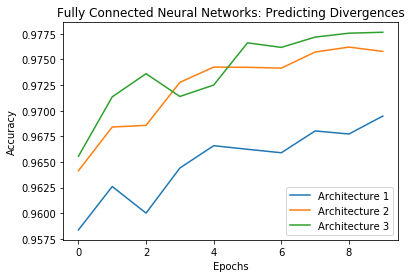

In [115]:
accuracies = [history.history['val_acc'] for history in histories]
labels = ['Architecture 1', 'Architecture 2', 'Architecture 3']
plt.title('Fully Connected Neural Networks: Predicting Divergences')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
for i, accuracy in enumerate(accuracies):
    plt.plot(accuracy, label=labels[i])
plt.legend()

In [24]:
Xtrain_conv, Xtest_conv, ytrain_conv, ytest_conv, input_shape = get_conv_data()

In [14]:
#iterate through different conv architectures and train the models to 
# regress an image onto a c-value
conv_architectures = [
    [[16, 3, 1], [32, 3, 2], [64, 3, 2], [64, 3, 2]],
]
fc_architectures = [ 
    [256, 128, 64, 32, 16]
]
y_scaling = 10

In [15]:
batch_size = 16
num_epochs = 20
for conv_architecture in conv_architectures:
    for fc_architecture in fc_architectures:
        model = create_network(fc_architecture, 2, True, conv_sizes = conv_architecture, use_fc=False, input_shape=[*input_shape, 1])
        hist = model.fit(Xtrain_conv, ytrain_conv*y_scaling, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.33)
        print(model.evaluate(Xtest_conv, ytest_conv*y_scaling))

Train on 965 samples, validate on 476 samples
Epoch 1/20
965/965 [==============================] - 9s 10ms/step - loss: 4.5680 - val_loss: 0.4529
Epoch 2/20
965/965 [==============================] - 8s 8ms/step - loss: 0.2403 - val_loss: 0.1186
Epoch 3/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0766 - val_loss: 0.0557
Epoch 4/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0462 - val_loss: 0.0445
Epoch 5/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0374 - val_loss: 0.0310
Epoch 6/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 7/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0087 - val_loss: 0.0148
Epoch 8/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0111 - val_loss: 0.0138
Epoch 9/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0164 - val_loss: 0.0325
Epoch 10/20
965/965 [==============================] 

In [16]:
print(model.evaluate(Xtest_conv, ytest_conv*y_scaling)) #see how well you did on the test set

711/711 [==============================] - 1s 2ms/step
0.0223805045397


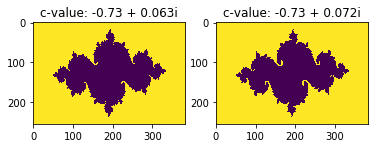

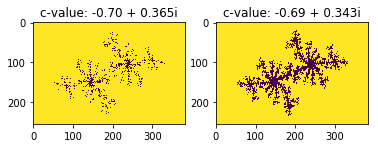

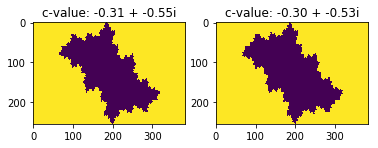

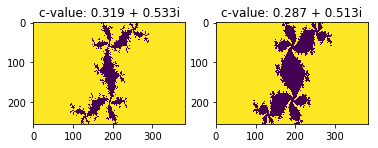

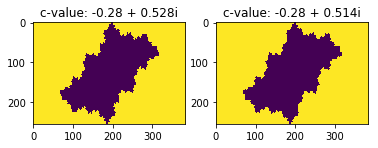

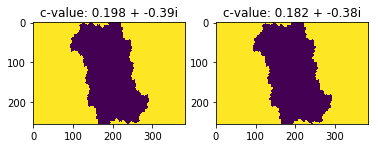

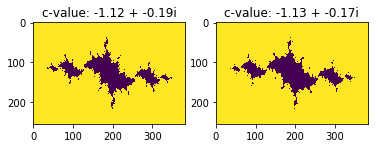

In [24]:
#Visualize the results of our model on the test set
# we display the generated julia set from the predicted c-value and compare it
# to the actual image that should have been generated 
test = [0, 12, 20, 48, 189, 420, 666]
i = 1
for example in test:
    pred = model.predict(np.reshape(Xtest_conv[example], (1, *Xtest_conv[48].shape)))[0]/y_scaling
    x, output_shape = generate_julia_set(128, pred[0] + pred[1]*1j)
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('c-value: ' + str(pred[0])[:5] + ' + ' + str(pred[1])[:5] +'i')
    plt.imshow(output_shape)
    plt.subplot(1, 2, 2)
    c = ytest_conv[example]
    x, output_shape = generate_julia_set(128, c[0] + c[1]*1j)
    plt.title('c-value: ' +str(c[0])[:5] + ' + '+ str(c[1])[:5] + 'i')
    plt.imshow(output_shape)

In [45]:
def autoencoder(conv_sizes, input_shape, hidden_sizes=[], latent_size=2, optimizer='adam'):
    model = Sequential()
    image_shape, extra_fc = down_conv(model, conv_sizes, input_shape, hidden_sizes, latent_size)
    conv_sizes.reverse()
    hidden_sizes.reverse()
    up_conv(model, conv_sizes, hidden_sizes, latent_size, image_shape, extra_fc)
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

In [46]:
def down_conv(model, conv_sizes, input_shape, hidden_sizes, latent_size):
    count = 0
    for size in conv_sizes:    
        num_filters, kernel_size, pool_size = size
        if count == 0:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    image_shape = model.output_shape
    model.add(Flatten())
    extra_fc = model.output_shape
    create_feedforward_network(model, hidden_sizes)
    model.add(Dense(latent_size, activation='relu')) #here add penalty to make similar to c 
    return image_shape[1:], extra_fc[1:][0]

In [47]:
def up_conv(model, conv_sizes, hidden_sizes, latent_size, image_shape, extra_fc):
    hidden_sizes = [latent_size] + hidden_sizes + [extra_fc]
    create_feedforward_network(model, hidden_sizes)
    model.add(Reshape(image_shape))  
    for size in conv_sizes:
        num_filters, kernel_size, up_size = size
        model.add(UpSampling2D(size=(up_size, up_size)))
        model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
    model.add(Convolution2D(1, kernel_size=(3, 3), padding='same', activation='relu'))

In [48]:
#create a convolutional auto-encoder with the specified latent size 
conv_sizes = [[16, 3, 2], [32, 3, 2], [64, 3, 2], [64, 3, 2]]
hidden_sizes=[512, 256, 64]
latent_size=2
model = autoencoder(conv_sizes, [*input_shape, 1], latent_size=latent_size)

In [49]:
batch_size=32
num_epochs =100

In [50]:
model.fit(Xtrain_conv, Xtrain_conv, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.2)

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 14s 12ms/step - loss: 0.4796 - val_loss: 0.3201
Epoch 2/100
1152/1152 [==============================] - 12s 11ms/step - loss: 0.3131 - val_loss: 0.3104
Epoch 3/100
1152/1152 [==============================] - 12s 10ms/step - loss: 0.3088 - val_loss: 0.3083
Epoch 4/100
1152/1152 [==============================] - 12s 10ms/step - loss: 0.3083 - val_loss: 0.3074
Epoch 5/100
1152/1152 [==============================] - 12s 10ms/step - loss: 0.3070 - val_loss: 0.3077
Epoch 6/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.3070 - val_loss: 0.3063
Epoch 7/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.3067 - val_loss: 0.3060
Epoch 8/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.3071 - val_loss: 0.3068
Epoch 9/100
1152/1152 [==============================] - 12s 10ms/step - loss: 0.3075 - val_loss: 0.3079
Epoch 10

KeyboardInterrupt: 

In [51]:
model.evaluate(Xtest_conv, Xtest_conv)

711/711 [==============================] - 2s 3ms/step


0.30519340129676581

In [25]:
model = load_model('autoencoder_latent_size2.h5')

In [26]:
layer_name = 'dense_2'
ilm = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [27]:
a = ilm.predict(np.reshape(Xtest_conv[0], (1, *Xtest_conv[0].shape)))[0]
ilm.compile(loss='mean_squared_error', optimizer='adam')
ilm.evaluate(Xtest_conv, ytest_conv) #see how well the latent layer is able to capture the c-value


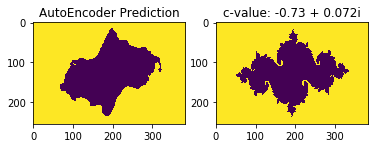

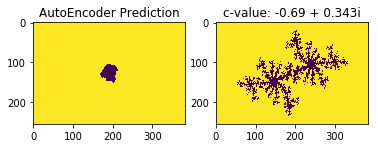

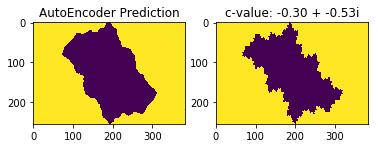

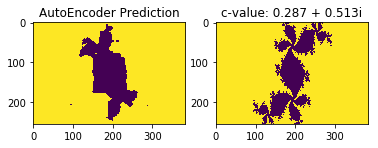

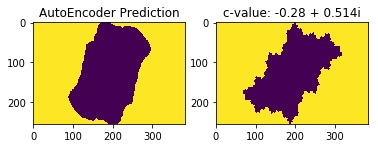

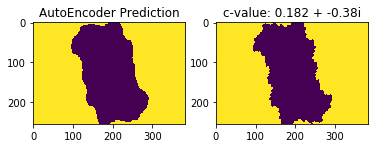

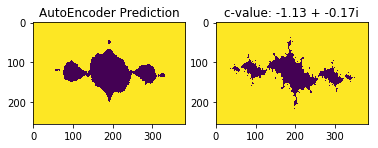

In [32]:
#visualize the direct auto-encoder predictions by running the autoencoder on the input
#images and then binarizing the output
test = [0, 12, 20, 48, 189, 420, 666]
i = 1
for example in test:
    pred = np.reshape(model.predict(np.reshape(Xtest_conv[example], (1, *Xtest_conv[48].shape))), (256, 384)) 
    test_output = np.where(pred>=.5, 1, 0)
    test_output = np.reshape(test_output, (256, 384))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('AutoEncoder Prediction')
    plt.imshow(test_output)
    plt.subplot(1, 2, 2)
    c = ytest_conv[example]
    x, output_shape = generate_julia_set(128, c[0] + c[1]*1j)
    plt.title('c-value: ' +str(c[0])[:5] + ' + '+ str(c[1])[:5] + 'i')
    plt.imshow(output_shape)